In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNA(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()

        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)

        return out

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()

        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)

    def forward(self, x):
        _,_,h,w = x.shape

        inner = self.conv1(x)
        inner = self.conv2(inner)
        #print(inner.shape)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)

        inner = F.upsample(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)

        return out

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=6):
        super().__init__()

        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)

        unet_block = None
        for i in range(num_downs-3):
            unet_block = UnetBlock(8*nc, 8*nc, 8*nc, unet_block)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)

        self.cna3 = CNA(nc, nc)

        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)

        return out

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool0 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 =  nn.MaxPool2d(kernel_size=2, return_indices=True)# 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 =  nn.MaxPool2d(kernel_size=2, return_indices=True)# 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=2) # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2) # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)

        self.batch_norm = nn.BatchNorm2d(num_features=1)
        self.batch_norm16 = nn.BatchNorm2d(num_features=16)
        self.batch_norm32 = nn.BatchNorm2d(num_features=32)
        self.batch_norm64 = nn.BatchNorm2d(num_features=64)
        self.batch_norm128 = nn.BatchNorm2d(num_features=128)
        self.relu = nn.ReLU()

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e0 = self.relu(self.batch_norm16(e0))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e1 = self.relu(self.batch_norm32(e1))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e2 = self.relu(self.batch_norm64(e2))
        e3, idx3 = self.pool3(self.enc_conv3(e2))
        e3 = self.relu(self.batch_norm128(e3))

        # bottleneck
        b = self.bottleneck_conv(e3)
        b = self.relu(self.batch_norm128(b))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, idx3))
        d0 = self.relu(self.batch_norm64(d0))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d1 = self.relu(self.batch_norm32(d1))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d2 = self.relu(self.batch_norm16(d2))
        d3 = self.dec_conv3(self.upsample3(d2, idx0)) # no activation

        return d3

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,  images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

        self.images_filenames = sorted(os.listdir(self.images_directory))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename), cv2.IMREAD_COLOR)[:,:,0:1]
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))

            #mask = torch.from_numpy(mask)
        return image, mask

In [ ]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
ds_images_path = '/content/gdrive/MyDrive/DLS_1/segmentation/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images'
ds_masks_path = '/content/gdrive/MyDrive/DLS_1/segmentation/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks'

In [ ]:
ds_train = MyDataset(ds_images_path, ds_masks_path, transform=train_transform)

In [ ]:
plt.imshow(ds_train[0][0])

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


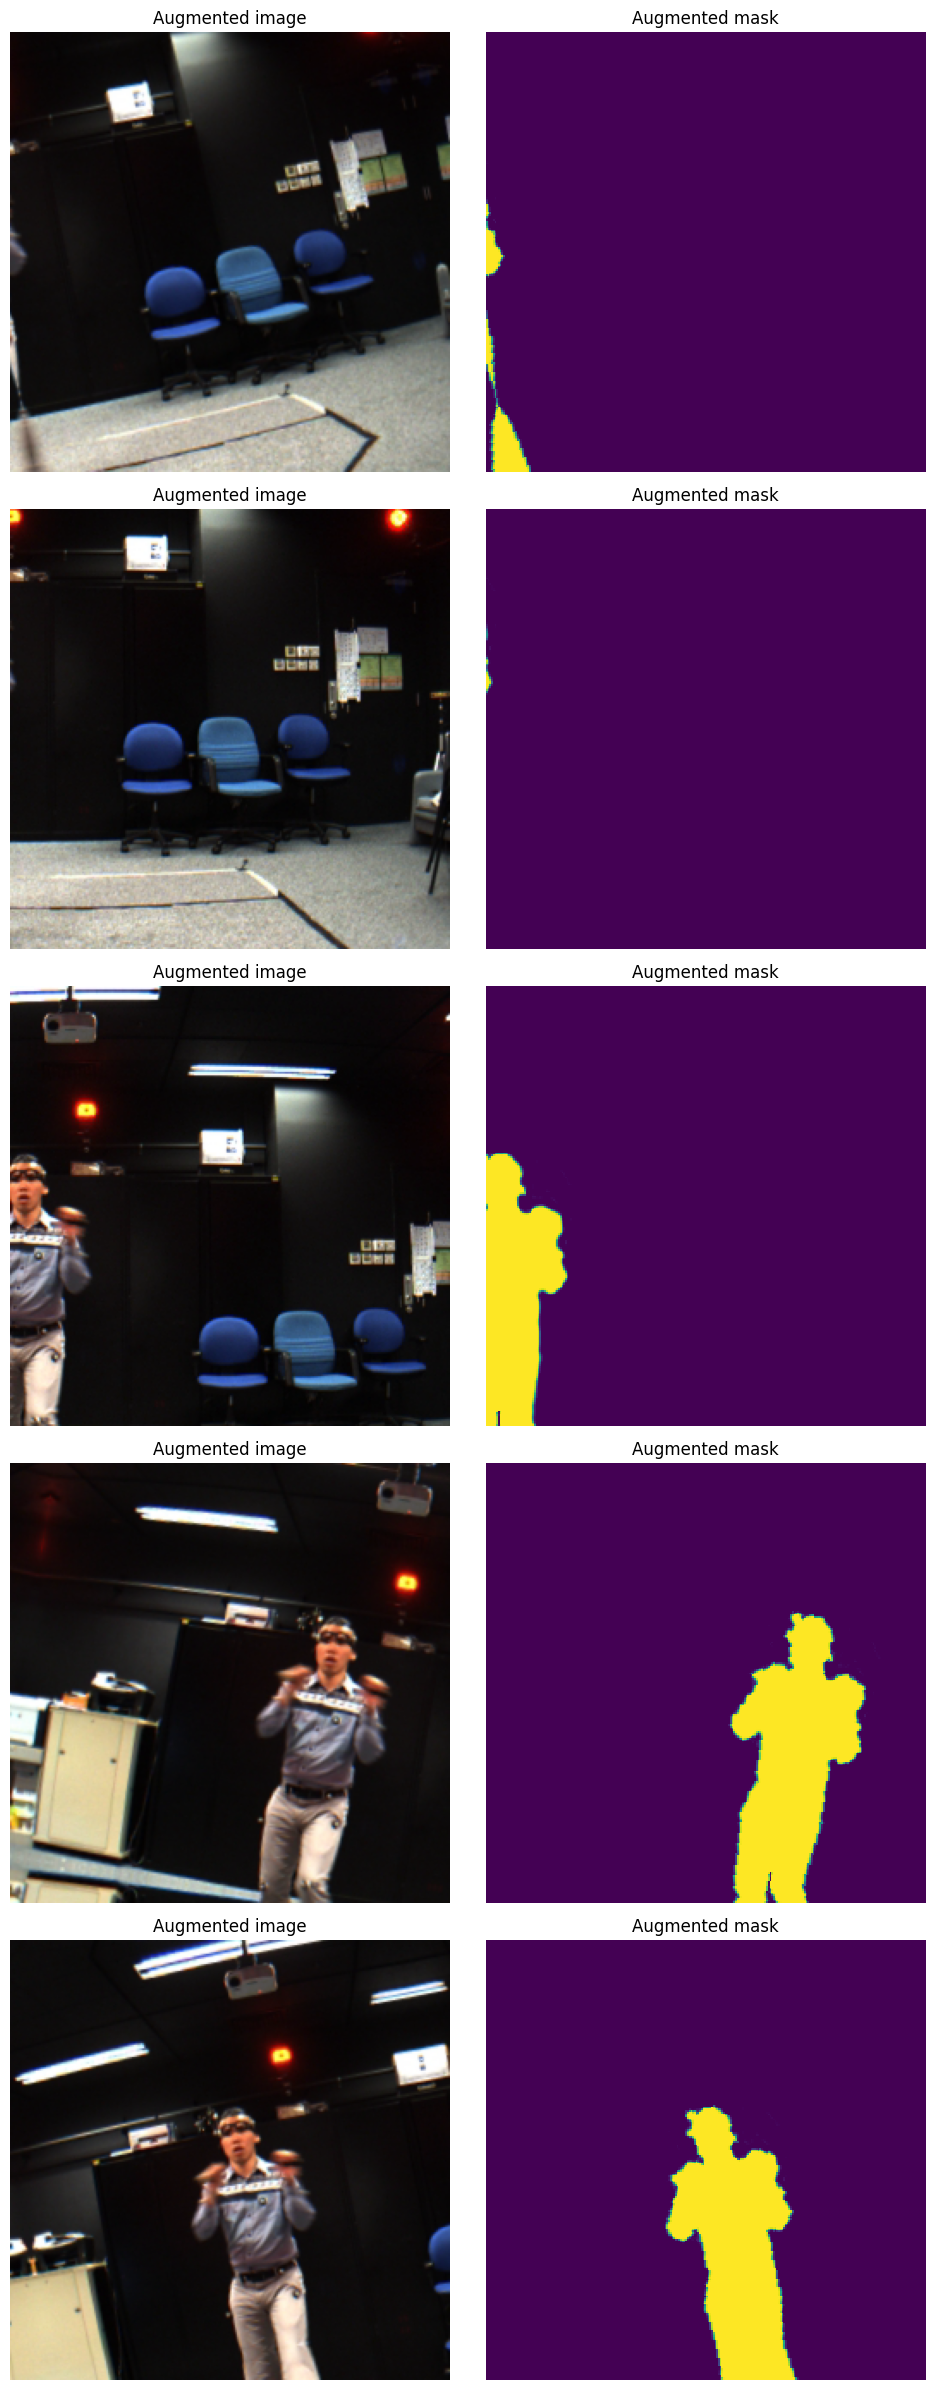

In [ ]:
visualize_augmentations(ds_train, 0)

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    ds_train, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=True
)

device = 'cpu'
unet_model = Unet(in_nc=3, nc=32, out_nc=1, num_downs=5)
unet_model = unet_model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
count_parameters(unet_model)

8440481

In [ ]:
model = SegNet()

In [ ]:
count_parameters(model)

342531

In [ ]:
epochs = 2
for epoch in range(epochs):
    print(f'epoch_{epoch}')
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, mask = sample
        img = img.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()

        pred = model(img)
        loss = loss_fn(pred, mask)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

    scheduler.step()
    #pbar.set_description(f'loss: {loss_item:.5f}\tlr: {scheduler.get_last_lr}')
    print(f'{loss_val/len(train_loader)}\t lr: {scheduler.get_last_lr()}')
    #print()

epoch_0


100%|██████████| 74/74 [03:01<00:00,  2.45s/it]


0.6872977243887411	 lr: [0.00059049]
epoch_1


100%|██████████| 74/74 [02:55<00:00,  2.37s/it]

0.6873157668758083	 lr: [0.000531441]


In [ ]:
img = ds_train[10][0].unsqueeze(0)
pred = unet_model(img)
pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)

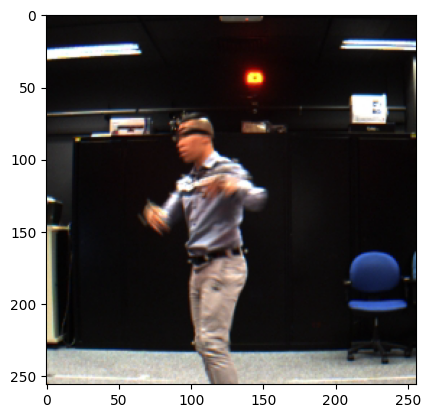

In [ ]:
img_np = img.detach().cpu().numpy()[0].transpose(1,2,0)
plt.imshow(img_np)

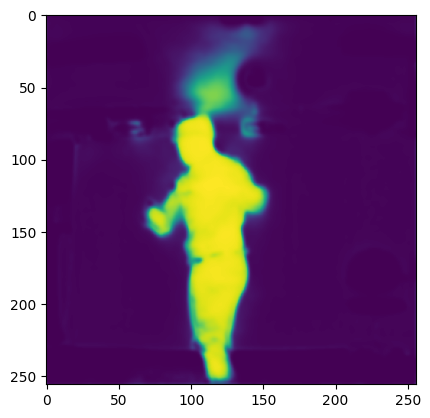

In [ ]:
plt.imshow(pred)